In [2]:
import gym
import matplotlib.pyplot as plt
import random
import numpy as np
from scipy import misc
%matplotlib inline

In [3]:
IMAGE_SIZE = 84

def display_state(state):
    assert state.shape == (84,84,4), "State shape error!"
    f, axarr = plt.subplots(1, 4, figsize=(16,5))
    for c in range(0,4):
        axarr[c].imshow(state[:,:,c], cmap=plt.cm.Greys);


def display_transition(memory):
    print memory[1]
    # displya post states
    states = [memory[0], memory[3]]
    id = 0
    f, axarr = plt.subplots(2, 4, figsize=(18,8))
    for state in states:
        for c in range(0,4):
            axarr[id][c].imshow(state[:,:,c], cmap=plt.cm.Greys);
            axarr[id][c].set_title('Action: ' + str(ACTION_NAMES[memory[1]]) + " Reward:" + str( memory[2]))
        id += 1
    plt.show()

def process_input(img):
    out = img[:195, :] # get only the playing area of the image
    r, g, b = out[:,:,0], out[:,:,1], out[:,:,2]
    out = r * (299./1000.) + g * (587./1000.) + b * (114./1000.)
    out = misc.imresize(out, (IMAGE_SIZE, IMAGE_SIZE), interp="bilinear")
    print "First state size:", out.nbytes, "bytes"
    print "Image type:", out.dtype
    return out

In [4]:
env = gym.make('DemonAttack-v0') #
env.frameskip = 16
ACTION_NAMES = env.get_action_meanings()
first_obs = process_input(env.reset())

[2016-12-02 16:58:23,583] Making new env: DemonAttack-v0


First state size: 7056 bytes
Image type: uint8


In [5]:
class ReplayMemory:
    def __init__(self, args):
        self.SIZE = args['size']
        self.AGENT_HISTORY_LENGTH = args['agent_history_length']
        self.MINIBATCH_SIZE = args['minibatch_size']
        self.IMAGE_SIZE = args['image_size']
        
        self.head_index = -1;
        self.actions = np.empty(self.size, dtype = np.uint8)
        self.rewards = np.empty(self.size, dtype = np.integer)
        self.observations = np.empty((self.size, args.screen_height, args.screen_width), dtype = np.uint8)
        self.terminals = np.empty(self.size, dtype = np.bool)
        
    def size(self):
        return len(self.observations)
    
    def init_memory(self, obs):
        self.observations = np.stack(tuple(obs for _ in range(self.AGENT_HISTORY_LENGTH)), axis=2)
        self.actions = np.array([0,0,0,0])
        self.rewards = np.array([0,0,0,0])
        self.terminals = np.array([False,False,False,False])
        assert self.observations.shape[2] == len(self.actions) == len(self.rewards) == len(self.terminals), "Invalid size"
        self.head_index = 3;
        
    def pop(self):
        self.observations = np.delete(self.observations, 0, axis=2)
        self.actions = np.delete(self.actions, 0)
        self.rewards = np.delete(self.rewards, 0)
        self.terminals = np.delete(self.terminals, 0)
        self.head_index -= 1
    
    def add(self, obs, action, reward, terminal):
        if self.head_index == (self.SIZE - 1):
            self.pop()
            
        assert (obs.shape == (self.IMAGE_SIZE, self.IMAGE_SIZE)), "Image shape not expected, please provide an (" + str(self.IMAGE_SIZE) + ", " + str(self.IMAGE_SIZE) + ") image."
        assert self.observations.shape[2] == len(self.actions) == len(self.rewards) == len(self.terminals), "Invalid size"
        obs = np.expand_dims(obs, axis=2)
        self.observations = np.append(self.observations, obs, axis=2)
        self.actions = np.append(self.actions, action)
        self.rewards = np.append(self.rewards, reward)
        self.terminals = np.append(self.terminals, terminal)
        self.head_index += 1
        
    def _get_state(self, index):
        state = self.observations[:,:,index - 3 : index + 1]
        print state.shape
        assert state.shape == (84,84,4), "State shape error!"
        return state
    
    def get_current_state(self):
        print self.observations.shape
        return self.observations[:,:,self.head_index - 3 : self.head_index + 1]
    
    def get_current_transition(self):
        minibatch = []
        pre_state = self._get_state(self.head_index - 1)
        post_state = self._get_state(self.head_index)
        minibatch.append([pre_state, self.actions[self.head_index], self.rewards[self.head_index], post_state, self.terminals[self.head_index]])
        return minibatch
    
    def get_minibatch(self):
        indexes = random.sample(range(self.AGENT_HISTORY_LENGTH, len(self.actions)), self.MINIBATCH_SIZE)
        print indexes
        minibatch = []
        for index in indexes:
            pre_state = self._get_state(index - 1)
            post_state = self._get_state(index)
            minibatch.append([pre_state, self.actions[index], self.rewards[index], post_state, self.terminals[index]])
        return minibatch

Size: 7056
(84, 84, 4)
First state size: 7056 bytes
(84, 84, 4)


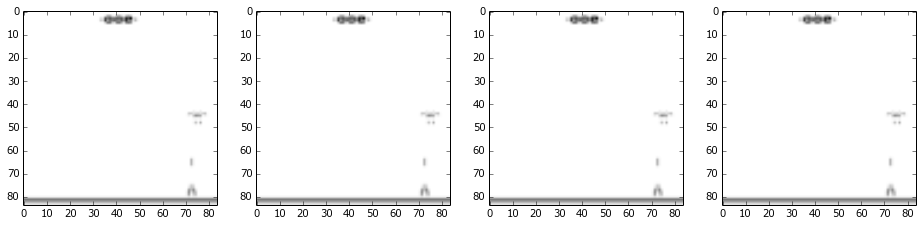

In [6]:
import sys

IMAGE_SIZE = 84
args = {}
args['size'] = 32
args['agent_history_length'] = 4
args['minibatch_size'] = 10
args['image_size'] = IMAGE_SIZE
memory = ReplayMemory(args)
memory.init_memory(first_obs)

img = memory.observations[:,:,0]
print "Size:", img.nbytes
state = memory.get_current_state()
print "First state size:", memory.observations[:,:,0].nbytes, "bytes"

print state.shape
display_state(state)
# misc.imshow(state[3])

In [ ]:
for _ in range(50):
    env.render()
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action) # take a random action
    # print observation.shape
    observation = process_input(observation)
    print "== First state size:", sys.getsizeof(observation), "bytes"
    memory.add(observation, action, reward, done)
    exit()

First state size: 7056 bytes
Image type: uint8
== First state size: 7168 bytes
First state size: 7056 bytes
Image type: uint8
== First state size: 7168 bytes
First state size: 7056 bytes
Image type: uint8
== First state size: 7168 bytes
First state size: 7056 bytes
Image type: uint8
== First state size: 7168 bytes
First state size: 7056 bytes
Image type: uint8
== First state size: 7168 bytes
First state size: 7056 bytes
Image type: uint8
== First state size: 7168 bytes
First state size: 7056 bytes
Image type: uint8
== First state size: 7168 bytes
First state size: 7056 bytes
Image type: uint8
== First state size: 7168 bytes
First state size: 7056 bytes
Image type: uint8
== First state size: 7168 bytes
First state size: 7056 bytes
Image type: uint8
== First state size: 7168 bytes
First state size: 7056 bytes
Image type: uint8
== First state size: 7168 bytes
First state size: 7056 bytes
Image type: uint8
== First state size: 7168 bytes
First state size: 7056 bytes
Image type: uint8
== Fi

In [ ]:
memory.observations.shape
state = memory.get_current_state()

print state.shape
print ACTION_NAMES
display_state(memory.observations[:,:, 28:32])

In [86]:
minibatch = memory.get_minibatch()

[10, 19, 20, 5, 6, 4, 25, 24, 15, 30]
(84, 84, 4)
(84, 84, 4)
(84, 84, 4)
(84, 84, 4)
(84, 84, 4)
(84, 84, 4)
(84, 84, 4)
(84, 84, 4)
(84, 84, 4)
(84, 84, 4)
(84, 84, 4)
(84, 84, 4)
(84, 84, 4)
(84, 84, 4)
(84, 84, 4)
(84, 84, 4)
(84, 84, 4)
(84, 84, 4)
(84, 84, 4)
(84, 84, 4)


2


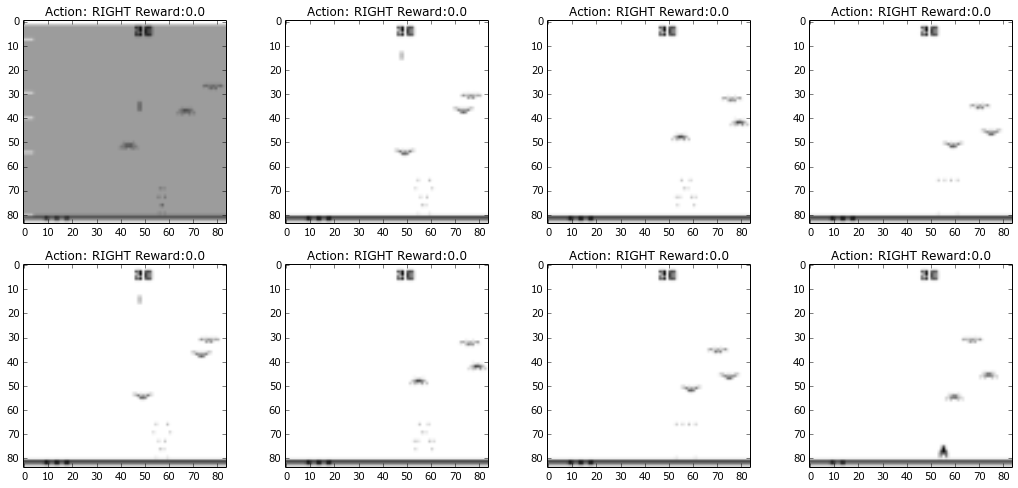

In [87]:
display_transition(minibatch[8])

(84, 84, 4)
(84, 84, 4)
1


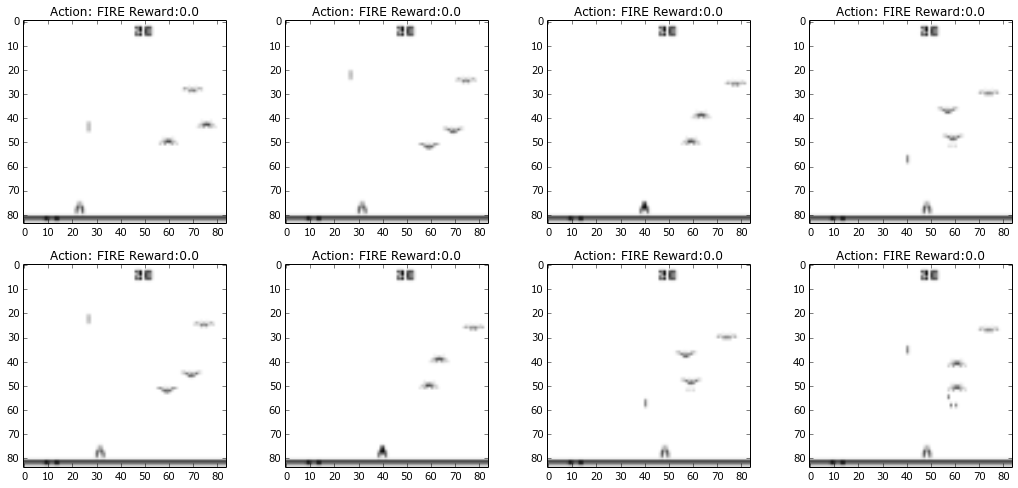

(84, 84, 32)


In [88]:
transition = memory.get_current_transition()
display_transition(transition[0])
print memory.observations.shape

In [52]:
from collections import deque
import numpy as np

In [53]:
state = []
pre_state = []
print "Ok"

Ok


In [54]:
a = 10
b = 100
state.append(a)
pre_state.append(a)

In [55]:
print id(pre_state) == id(state)
print id(pre_state[0])
print id(state[0])
l = [state, pre_state]

False
26194080
26194080


In [56]:
print l

[[10], [10]]


In [57]:
state.append(b)
print l

[[10, 100], [10]]


In [43]:
print pre_state[0] == state[0]
print id(pre_state[0]) == id(state[0])

True
True
